In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from functions_SqRA import grid1, adjancency_matrix_sparse, build_sqra, build_sqra_dec1
from pcca import pcca


from functions_Gillespie import generate_indices, generate_tildeQrows, rates_gillespie, perturbed_rates_gillespie
from functions_Gillespie import jump_gillespie

np.random.seed(0) 

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

## Potential energy function

In [3]:
def V1(x):
    return 1*(x**2 - 1) ** 2 + 1 * x

def V2(y):
    return 2*y ** 2

def V12(x,y):
    #return 1/np.sqrt(x**2 + y**2)
    return x * y

def V(c, X):
    return V1(X[0]) + V2(X[1]) + c * V12(X[0], X[1])

## Grid definition

In [4]:
# Number of dimensions
Nd       = 2

a = 3.4
xcenters, xedges, xbins, dx = grid1(-a, a, 51)
ycenters, yedges, ybins, dy = grid1(-a, a, 51)

bins = np.array([xbins, ybins])
DX   = np.array([dx, dy])

grid = np.meshgrid(xcenters, ycenters)
X    = np.stack([grid[0], grid[1]])

# Total number of bins
Nbins = xbins * ybins
print("Total number of bins: ", Nbins)

Total number of bins:  2500


## Exact PCCA+

In [5]:
# Stationary distributions
pi1  = np.exp(- beta * V1(xcenters) )
pi2  = np.exp(- beta * V2(ycenters) )
pi12 = np.exp(- beta * V12(X[0], X[1]).flatten('C') )
sqrt_pi12 = np.sqrt(pi12)

PI   = np.array([pi1, pi2], dtype=object)

## SqRA of subsystems 1 and 2
#Ai, Ii, Qoi, Ei are lists containing the matrices of the uncoupled subsystems
Ai, Ii, Qoi, Ei =  build_sqra_dec1(D, PI, DX, bins)

Q1  = Qoi[0] - Ei[0]
Q2  = Qoi[1] - Ei[1]

## Build the Qo matrix of the uncoupled system as kronacker sum of Qo1 and Qo2
# off-diagonal matrix of the uncoupled system
Qo             = 0

for i in range(Nd):
    Qo = scipy.sparse.kronsum(Qo, Qoi[i])
    
E  =  scipy.sparse.spdiags( Qo.sum(axis=1).T, 0, Nbins, Nbins )
Q  =  Qo - E


# Build diagonal matrix of the coupling term D12inv and D12
SQRA        = np.sqrt(pi12)
D12         = scipy.sparse.spdiags( SQRA,     0, Nbins, Nbins) #.toarray()
D12inv      = scipy.sparse.spdiags( 1 / SQRA, 0, Nbins, Nbins)  

# Multiply Qo by D12inv and D12
tildeQo     = D12inv * Qo * D12

# Build rate matrix Q of coupled dynamics
tildeE      = scipy.sparse.spdiags( tildeQo.sum(axis=1).T, 0, Nbins, Nbins )
tildeQ      = tildeQo - tildeE 
tildeQ = tildeQ.toarray()

In [6]:
## PCCA+

# System 1
chi1, e1, S1, schurevecs1 = pcca(Q1.toarray(), 2, massmatrix=None)
Qc1 = np.linalg.pinv(chi1).dot(Q1.toarray().dot(chi1))

print(" ")
print(Qc1)

# System 2
chi2, e2, S2, schurevecs2 = pcca(Q2.toarray(), 1, massmatrix=None)
Qc2 = np.linalg.pinv(chi2).dot(Q2.toarray().dot(chi2))

print(" ")
print(Qc2)

# Uncouled system
Qc  = scipy.sparse.kronsum(Qc1, Qc2)
chi = scipy.sparse.kron(chi2, chi1)
chi = chi.toarray()

print(" ")
print(Qc.toarray())

# Perturbed system
tildeChi, tildee, tildeS, tildeSchurevecs = pcca(tildeQ, 2, massmatrix=None)
tildeQc = np.linalg.pinv(tildeChi).dot(tildeQ.dot(tildeChi))

print(" ")
print(tildeQc)

 
[[-1.45126051  1.45126051]
 [ 0.74196889 -0.74196889]]
 
[[-2.84217094e-16]]
 
[[-1.45126051  1.45126051]
 [ 0.74196889 -0.74196889]]
 
[[-1.2169658  1.2169658]
 [ 0.68686   -0.68686  ]]


In [17]:
def scale_and_shift(array):

    minarr = np.min(array)
    maxarr = np.max(array)
    new_array = (array - minarr) / (maxarr - minarr)
    #new_array = (array - minarr) / np.max(np.abs(array - minarr))
    return new_array 

# Calculate approximated Qc
KTAU = np.array([0.1,1,2,5, 10, 15])*0.1

k12 = np.zeros(len(KTAU))
k21 = np.zeros(len(KTAU))

k12_Q = np.zeros(len(KTAU))
k21_Q = np.zeros(len(KTAU))

for kk,t in enumerate(KTAU):
    
    # Use the full matrix  
    
    
    tildeK = scipy.linalg.expm(tildeQ * t)
    #tildeK = tildeQ * t + np.diag(np.ones(Nbins))
    chi1 = np.matmul(tildeK, chi)
    M    = np.linalg.lstsq(chi1, chi)[0]
    hatQc= scipy.linalg.logm(np.linalg.inv(M)) / t
    #hatQc= (np.linalg.inv(M) - np.diag(np.ones(len(M)))) / t
    k12[kk] = hatQc[0,1]
    k21[kk] = hatQc[1,0]
    
    
    # Use only certain rows of Ktau randomly selected
    
    
    """
    # Generate a set of initial points
    Npoints = 1000
    i0      = np.random.randint(10, 40, Npoints)
    j0      = np.random.randint(15, 35, Npoints)
    s0      = j0 + ybins * i0
    s0      = np.sort(s0)
    #tildeK = scipy.linalg.expm(tildeQ * t)
    tildeK = tildeQ[s0,:][:,s0] * t + np.diag(np.ones(Npoints))
    hat_chi =np.matmul(tildeK, chi[s0,:])
    M = np.linalg.lstsq(hat_chi, chi[s0,:])[0]
    M[0,:] = M[0,:] / np.sum(M[0,:])
    M[1,:] = M[1,:] / np.sum(M[1,:])
    #hatQc= scipy.linalg.logm(np.linalg.inv(M)) / t
    hatQc= (np.linalg.inv(M) - np.diag(np.ones(len(M)))) / t
    k12[kk] = hatQc[0,1]
    k21[kk] = hatQc[1,0]
    """
    
    oldChi  = chi.copy()
    hatChi  = tildeQ.dot(oldChi)
    hatQc   = np.linalg.lstsq(oldChi, hatChi)[0]
    k12_Q[kk] = hatQc[0,1]
    k21_Q[kk] = hatQc[1,0]
     
    # Use tildeQ on chi
    #hatChi  = Q.dot(chi)
    
    #for n in range(0):
    #    hatChi = tildeQ.dot(hatChi)
    
    """
    #hatQc   = np.linalg.lstsq(chi, tildeQ.dot(chi))[0]
    Npoints = 100
    i0      = np.random.randint(10, 40, Npoints)
    j0      = np.random.randint(15, 35, Npoints)
    s0      = j0 + ybins * i0
    s0      = np.sort(s0)
    #s0      = np.arange(Nbins-2000)
    oldChi  = chi.copy()
    hatChi  = tildeQ[s0,:][:,s0].dot(oldChi[s0,:])
    #oldChi  = hatChi.copy()
    #hatChi  = tildeQ.dot(oldChi)

    M=scipy.linalg.expm(np.linalg.lstsq(oldChi[s0,:], hatChi)[0])
    M[0,:] = M[0,:] / np.sum(M[0,:])
    M[1,:] = M[1,:] / np.sum(M[1,:])
    hatQc = scipy.linalg.logm(M)

    k12_Q[kk] = hatQc[0,1]
    k21_Q[kk] = hatQc[1,0]
    
    """
    # Use only certain rows of tildeQ randomly selected
    """
    inds = np.random.randint(0,2500, 10)
    inds = np.sort(inds)
    inds = np.unique(inds)
    hat_chi =np.matmul(tildeQ[inds,:][:,inds], chi[inds,:])
    hatQc = np.linalg.lstsq(hat_chi, chi[inds,:])[0]
    #M[0,:] = M[0,:] / np.sum(M[0,:])
    #M[1,:] = M[1,:] / np.sum(M[1,:])
    #hatQc= scipy.linalg.logm(np.linalg.inv(M)) / t
    
    
    k12[kk] = - r[0] - r[1]
    k21[kk] = hatQc[1,0]
    """
    

/tmp/ipykernel_32005/3604411652.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M    = np.linalg.lstsq(chi1, chi)[0]
/tmp/ipykernel_32005/3604411652.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  hatQc   = np.linalg.lstsq(oldChi, hatChi)[0]


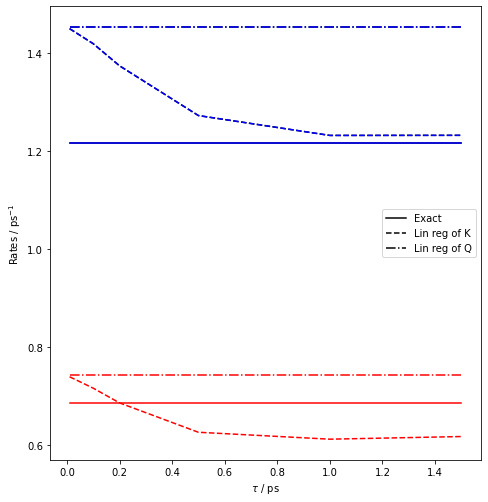

In [20]:
plt.rcParams.update({'font.size': 10})

# Plot potential
fig = plt.figure(figsize=(16*in2cm, 16*in2cm))

ax = fig.add_subplot(1, 1, 1)

# Exact
ax.plot(KTAU, tildeQc[0,1] * np.ones(len(KTAU)), 'k', label ='Exact')
ax.plot(KTAU, tildeQc[0,1] * np.ones(len(KTAU)), 'b')
ax.plot(KTAU, tildeQc[1,0] * np.ones(len(KTAU)), 'r')


# Approximation
ax.plot(KTAU, k12, 'k--', label = 'Lin reg of K')
ax.plot(KTAU, k12, 'b--')
ax.plot(KTAU, k21, 'r--')

ax.plot(KTAU, k12_Q, 'k-.', label = 'Lin reg of Q')
ax.plot(KTAU, k12_Q, 'b-.')
ax.plot(KTAU, k21_Q, 'r-.')

#ax.set_ylim((0, 2.0))
ax.set_xlabel(r'$\tau$ / ps')
ax.set_ylabel(r'Rates / ps$^{-1}$');

ax.legend()

#ax.set_ylabel(r'Rates / ps$^{-1}$');

plt.subplots_adjust(left=0, bottom=0, right=0.95, top=1, wspace=0.4, hspace=0.1)
#fig.savefig('figures/rate_conv1.pdf', format='pdf', dpi=900, bbox_inches='tight')

In [24]:
np.linalg.pinv(chi).dot(tildeQ.dot(chi))



array([[-1.45333864,  1.45333864],
       [ 0.74303135, -0.74303135]])

In [ ]:
def generate_tildeQrows(Q1,Q2,sqrt_pi12,i,j,xbins,ybins):
    """
    tildeQrows = generate_tildeQrows(Q1,Q2,sqrt_pi12,i,j,ybins)
    """
    Nreps = i.shape[0]
    
    #sqrt_ps1_i2 = np.array([sqrt_ps1_i2])
    
    # current state
    s  = i + ybins * j
    
    s1_plus  = (i + 1) + ybins * j
    s1_minus = (i - 1) + ybins * j
    s2_plus  =    i    + ybins * ( j + 1 )
    s2_minus =    i    + ybins * ( j - 1 ) 
    
    tildeQrows = np.zeros((Nreps, xbins * ybins))
    
    # fancy indexing
    tildeQrows[np.arange(Nreps),s1_plus]  = Q1[i,i+1] * sqrt_pi12[s1_plus]  / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s1_minus] = Q1[i,i-1] * sqrt_pi12[s1_minus] / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s2_plus]  = Q2[j,j+1] * sqrt_pi12[s2_plus]  / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s2_minus] = Q2[j,j-1] * sqrt_pi12[s2_minus] / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s]        = - np.sum(tildeQrows, axis=1)
    
    return tildeQrows

def perturbed_rates_gillespie(tildeQrows):
    """
    Q : Rate matrix
    norm_rates, sr, cdf = perturbed_rates(tildeQrows)
    """

    # Select the rows
    r          = tildeQrows

    # Take the absolute value
    r          = np.abs(r)

    # Calculate the sum
    sr             = r.sum(axis=1)
    invsr          = np.diag(1/sr)

    # Normalize
    norm_rates = invsr @ r

    # CDF
    cdf  = np.cumsum(norm_rates, axis=1)

    return norm_rates, sr, cdf

def gillespie_trajs(tau, Q1, Q2, sqrt_pi12, s1_i, s2_i):
    """
    tau       := required length of trajectories
    Q1, Q2    := rate matrices of subsystems
    sqrt_ps1_i2 := vector with perturbation
    s1_i        := starting indices of system 1 
    s2_i        := starting indices of system 2
    
    s12_j, realtime = gillespie_trajs(tau, Q1d, Q2d, sqrt_pi12, s1_i, s2_i)
    """
    Nreps = s1_i.shape[0]
    
    # 1-d array where to store real time
    realtime     = np.zeros( Nreps)
        
    # x,y arrays
    #x = np.zeros((Gsteps, Nreps))
    #y = np.zeros((Gsteps, Nreps))

    #x[0,:] = np.ones(Nreps) * xcenters[s1_i]
    #y[0,:] = np.ones(Nreps) * ycenters[s2_i]
    
    # if tau_reps[r]==0, then continue the simulation
    tau_reps = np.zeros(Nreps)
    
    s12_j    = np.zeros(Nreps)
    
    #for g in range(Gsteps-1):
    while np.sum(tau_reps)<Nreps:

        tildeQrows = generate_tildeQrows(Q1, Q2, sqrt_pi12, s1_i, s2_i, xbins, ybins)
        norm_rates, sr, cdf = perturbed_rates_gillespie(tildeQrows)

        # WHEN does the next process happen?   
        u1            = np.random.uniform(0, 1, Nreps)
        next_time     = - np.log(u1) / sr
        realtime      = realtime + next_time

        # WHERE does the next process end after tau?
        temp_s12_j = jump_gillespie(cdf)
        """
        for r in range(Nreps):
            if tau_reps[r] == 0 and realtime[r] >= tau:
                s12_j[r]    = temp_s12_j[r]
                tau_reps[r] = 1
        """
        s12_j[(tau_reps == 0) & (realtime >= tau)]    = temp_s12_j[(tau_reps == 0) & (realtime >= tau)]
        tau_reps[(tau_reps == 0) & (realtime >= tau)] = 1
            
        s1_i       = states2D[temp_s12_j.astype('int'),0].astype('int')
        s2_i       = states2D[temp_s12_j.astype('int'),1].astype('int')
        
        # Check boundaries
        s1_i[s1_i==0] = 1
        s1_i[s1_i==xbins-1] = xbins-2

        s2_i[s2_i==0] = 1
        s2_i[s2_i==ybins-1] = ybins-2

        #x[g+1,:] = xcenters[s1_i]
        #y[g+1,:] = ycenters[s2_i]

    return s12_j.astype('int'), realtime

In [ ]:
def generate_tildeQrows(Q1,Q2,sqrt_pi12,i,j,xbins,ybins):
    """
    tildeQrows = generate_tildeQrows(Q1,Q2,sqrt_pi12,i,j,ybins)
    """
    Nreps = i.shape[0]
    
    #sqrt_pi12 = np.array([sqrt_pi12])
    
    # current state
    s  = i + ybins * j
    
    s1_plus  = (i + 1) + ybins * j
    s1_minus = (i - 1) + ybins * j
    s2_plus  =    i    + ybins * ( j + 1 )
    s2_minus =    i    + ybins * ( j - 1 ) 
    
    tildeQrows = np.zeros((Nreps, xbins * ybins))
    
    # fancy indexing
    tildeQrows[np.arange(Nreps),s1_plus]  = Q1[i,i+1] * sqrt_pi12[s1_plus]  / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s1_minus] = Q1[i,i-1] * sqrt_pi12[s1_minus] / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s2_plus]  = Q2[j,j+1] * sqrt_pi12[s2_plus]  / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s2_minus] = Q2[j,j-1] * sqrt_pi12[s2_minus] / sqrt_pi12[s]
    tildeQrows[np.arange(Nreps),s]        = - np.sum(tildeQrows, axis=1)
    
    return tildeQrows

def perturbed_rates_gillespie(tildeQrows):
    """
    Q : Rate matrix
    norm_rates, sr, cdf = perturbed_rates(tildeQrows)
    """

    # Select the rows
    r          = tildeQrows

    # Take the absolute value
    r          = np.abs(r)

    # Calculate the sum
    sr             = r.sum(axis=1)
    invsr          = np.diag(1/sr)

    # Normalize
    norm_rates = invsr @ r

    # CDF
    cdf  = np.cumsum(norm_rates, axis=1)

    return norm_rates, sr, cdf

def gillespie_trajs(Q1, Q2, sqrt_pi12, ii, jj, xbins, ybins, tau):
    """
    x,y,ii,jj,s,realtime = gillespie_trajs(Q1d, Q2d, sqrt_pi12, ii, jj, xbins, ybins, Gsteps)
    """
    Nreps = ii.shape[0]
    
    # 1-d array where to store real time
    #realtime     = np.zeros((Gsteps, Nreps))
    realtime     = np.zeros(Nreps)
        
    # x,y arrays
    #x = np.zeros((Gsteps, Nreps))
    #y = np.zeros((Gsteps, Nreps))

    #x[0,:] = np.ones(Nreps) * xcenters[ii]
    #y[0,:] = np.ones(Nreps) * ycenters[jj]
    
    
    #for g in range(Gsteps-1):
    avg_time = 0
    while avg_time<tau:
        s  = ii + ybins * jj

        tildeQrows = generate_tildeQrows(Q1, Q2, sqrt_pi12, ii, jj, xbins, ybins)
        norm_rates, sr, cdf = perturbed_rates_gillespie(tildeQrows)

        # WHEN does the next process happen?   
        u1            = np.random.uniform(0, 1, Nreps)
        realtime      = realtime - np.log(u1) / sr
        avg_time      = np.mean(realtime)
        
        # WHERE does the next process end after tau?
        s = jump_gillespie(cdf)

        ii       = states2D[s,0].astype('int')
        jj       = states2D[s,1].astype('int')

        # Check boundaries
        ii[ii==0] = 1
        ii[ii==xbins-1] = xbins-2

        jj[jj==0] = 1
        jj[jj==ybins-1] = ybins-2

        #x[g+1,:] = xcenters[ii]
        #y[g+1,:] = ycenters[jj]

    return ii,jj,s,realtime

## Koopman operator from Gillespie - dependence on number points

In [ ]:
## Gillespie algorithm
Q1d = Q1.toarray()
Q2d = Q2.toarray()

#NPOINTS =  np.logspace(np.log(10), np.log(1000), 10, base=np.exp(1)).astype('int')
NPOINTS = np.linspace(10,50, 5).astype('int')

#tildeQcApp1 = np.empty(len(NPOINTS), dtype=object)
tildeQcApp1 = np.zeros((2,2,len(NPOINTS)))

# States2D contains the indeces of all states: i, j, i+ybins*j
states2D = generate_indices(xbins, ybins)

# Number of replicas per point
Nreps        = 100

# Number of Gillespie steps
#Gsteps       = 100
tau=0.5   

  
for pp, Npoints in tqdm(enumerate(NPOINTS)):
    print(pp)
    #prevTildeChiGill = np.zeros((Npoints,2))
    tildeChiGill = np.zeros((Npoints,2))

    # Generate a set of initial points
    i0      = np.random.randint(10, 40, Npoints)
    j0      = np.random.randint(15, 35, Npoints)
    s0      = i0 + ybins * j0

    all_realtime = 0

    for p in tqdm(range(Npoints)):

        # 1-d array where to store real time
        realtime     = np.zeros(Nreps)

        ii = np.ones(Nreps) * i0[p]
        ii = ii.astype(int)

        jj = np.ones(Nreps) * j0[p]
        jj = jj.astype(int)

        ii,jj,s,realtime = gillespie_trajs(Q1d, Q2d, sqrt_pi12, ii, jj, xbins, ybins, tau)
            
        tildeChiGill[p,0] = np.mean(chi[s,0])
        tildeChiGill[p,1] = np.mean(chi[s,1]) 
        
        #prevTildeChiGill[:,0] = scale_and_shift(prevTildeChiGill[:,0])
        #prevTildeChiGill[:,1] = scale_and_shift(prevTildeChiGill[:,1])
        
        #x,y,ii,jj,s,realtime = gillespie_trajs(Q1d, Q2d, sqrt_pi12, ii, jj, xbins, ybins, Gsteps)
        
        #nextTildeChiGill[p,0] = np.mean(prevTildeChiGill[p,0])
        #nextTildeChiGill[p,1] = np.mean(prevTildeChiGill[p,1]) 
            
        all_realtime = all_realtime + np.sum(realtime)

    mean_tau = all_realtime / (Nreps*Npoints)

    # Linear regression
    M = np.linalg.lstsq(tildeChiGill, chi[s0,:])[0]

    # Normalize
    M[0,:] = M[0,:] / np.sum(M[0,:])
    M[1,:] = M[1,:] / np.sum(M[1,:])

    tildeQcApp1[:,:,pp] = scipy.linalg.logm(np.linalg.inv(M)) / mean_tau
    print(tildeQcApp1[:,:,pp])

"""
Xtau  =  np.zeros(Nreps)
Ytau  =  np.zeros(Nreps)
tau   =  np.min(realtime[-1,:])

for r in range(Nreps):
    
    idx = np.argwhere(realtime[:,r]<=tau)
    Xtau[r] = x[idx[-1],r]
    Ytau[r] = y[idx[-1],r]
""";

## Koopman operator from Gillespie - dependence on tau

In [ ]:
## Gillespie algorithm
Q1d = Q1.toarray()
Q2d = Q2.toarray()

#NPOINTS =  np.logspace(np.log(10), np.log(1000), 10, base=np.exp(1)).astype('int')
#NGSTEPS = np.linspace(10,1200, 4).astype('int')
#NTAUS   = np.array([1,2,5, 10, 15])*0.1

#tildeQcApp1 = np.empty(len(NPOINTS), dtype=object)
tildeQcApp2 = np.zeros((2,2,len(KTAU)))


Npoints      = 10

# Initial points
i0      = np.random.randint(10,40,Npoints)
j0      = np.random.randint(10,40,Npoints)
s0      = i0 + ybins * j0

# States2D contains the indeces of all states: i, j, i+ybins*j
states2D = generate_indices(xbins, ybins)

# Number of replicas per point
Nreps        = 500
    
#for gg, Gsteps in enumerate(NGSTEPS):
for gg, tau in tqdm(enumerate(KTAU)):
    
    if gg==4:
        Nreps = 1000
        
    print("tau=",tau)
    
    tildeChiGill = np.zeros((Npoints,2))



    all_realtime = 0

    for p in tqdm(range(Npoints)):

        ii = np.ones(Nreps) * i0[p]
        ii = ii.astype(int)

        jj = np.ones(Nreps) * j0[p]
        jj = jj.astype(int)

        ii,jj,s,realtime = gillespie_trajs(Q1d, Q2d, sqrt_pi12, ii, jj, xbins, ybins, tau)

        tildeChiGill[p,0] = np.mean(chi[s,0])
        tildeChiGill[p,1] = np.mean(chi[s,1])

        all_realtime = all_realtime + np.sum(realtime)

    mean_tau = all_realtime / (Nreps*Npoints)
    print("mean_tau=",mean_tau)
    # Linear regression
    M = np.linalg.lstsq(tildeChiGill, chi[s0,:])[0]
    
    # Normalize
    M[0,:] = M[0,:] / np.sum(M[0,:])
    M[1,:] = M[1,:] / np.sum(M[1,:])

    tildeQcApp2[:,:,gg] = scipy.linalg.logm(np.linalg.inv(M)) / mean_tau
    print(tildeQcApp2[:,:,gg])

"""
Xtau  =  np.zeros(Nreps)
Ytau  =  np.zeros(Nreps)
tau   =  np.min(realtime[-1,:])

for r in range(Nreps):
    
    idx = np.argwhere(realtime[:,r]<=tau)
    Xtau[r] = x[idx[-1],r]
    Ytau[r] = y[idx[-1],r]
""";

In [ ]:
plt.rcParams.update({'font.size': 10})

# Plot potential
fig = plt.figure(figsize=(8*in2cm, 5*in2cm))

ax = fig.add_subplot(1, 2, 1)

# Exact
ax.plot(NPOINTS, tildeQc[0,1] * np.ones(len(NPOINTS)), 'b')
ax.plot(NPOINTS, tildeQc[1,0] * np.ones(len(NPOINTS)), 'r')

# Approximation
ax.plot(NPOINTS, hatQc[0,1] * np.ones(len(NPOINTS)), 'b--')
ax.plot(NPOINTS, hatQc[1,0] * np.ones(len(NPOINTS)), 'r--')


# Numerics
ax.plot(NPOINTS, tildeQcApp1[0,1,:] * np.ones(len(NPOINTS)), 'bs')
ax.plot(NPOINTS, tildeQcApp1[1,0,:] * np.ones(len(NPOINTS)), 'rs')
ax.set_ylim((0, 2.5))
ax.set_xlabel('Num. points')
ax.set_ylabel(r'Rates / ps$^{-1}$');


ax = fig.add_subplot(1, 2, 2)

# Exact
ax.plot(KTAU, tildeQc[0,1] * np.ones(len(KTAU)), 'b')
ax.plot(KTAU, tildeQc[1,0] * np.ones(len(KTAU)), 'r')

# Approximation
ax.plot(KTAU, k12, 'b--')
ax.plot(KTAU, k21, 'r--')


# Numerics
ax.plot(KTAU, tildeQcApp2[0,1,:] * np.ones(len(KTAU)), 'bs')
ax.plot(KTAU, tildeQcApp2[1,0,:] * np.ones(len(KTAU)), 'rs')


ax.set_ylim((0, 2.5))
ax.set_xlabel(r'$\tau$ / ps')
#ax.set_ylabel(r'Rates / ps$^{-1}$');

plt.subplots_adjust(left=0, bottom=0, right=0.95, top=1, wspace=0.4, hspace=0.1)
#fig.savefig('figures/eigenvectors.pdf', format='pdf', dpi=900, bbox_inches='tight')

In [ ]:
#filename = 'results_gillespie.npy'
#np.save(filename, [NPOINTS, tildeQc, hatQc, tildeQcApp1, KTAU, k12, k21, tildeQcApp2])